# Color code memory experiment on IBM

In [1]:
from collections import Counter
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

import cirq
import stim
import stimcirq

import qiskit
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
import datetime


time_key = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M:%S")  # For saving results.

## Set parameters

In [29]:
distance = 3                        # Color code distance.
nshots = 20_000                     # Number of samples/shots
idle_strategy: str = "wait"         # Either "idle" = delay gate or "drive" = (logical) X gate.
depths = [0, 20, 40, 60, 80, 100]         # Depth of idle circuit.

simulator = stimcirq.StimSampler()  # To sample codewords.

In [7]:
service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
computer = service.backend("ibm_kingston")
sampler = Sampler(computer)

# Good qubits on Fez April 4.
layout = {
    3: [1, 2, 3, 4, 5, 6, 7],
    5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27],
}

## Helper functions

In [8]:
import dataclasses


@dataclasses.dataclass
class Tile:
    qubits: list
    color: str


def make_color_code_tiles(*, base_data_width):
    if not (base_data_width % 2 == 1 and base_data_width >= 3):
        raise ValueError(f"{base_data_width=} wasn't an odd number at least as large as 3.")
    w = base_data_width * 2 - 1

    def is_in_bounds(q: complex) -> bool:

        if q.imag < 0:

            return False
        if q.imag * 2 > q.real * 3:

            return False
        if q.imag * 2 > (w - q.real) * 3:

            return False
        return True


    tiles = []
    hexagon_offsets = [-1, +1j, +1j + 1, +2, -1j + 1, -1j]
    for x in range(1, w, 2):
        for y in range((x // 2) % 2, w, 2):
            q = x + 1j * y

            tile = Tile(
                color=['red', 'green', 'blue'][y % 3],

            
                qubits=[
                    q + d
                    for d in hexagon_offsets
                    if is_in_bounds(q + d)
                ],
            )

            if len(tile.qubits) in [4, 6]:
                tiles.append(tile)

    return tiles

def get_stabilizer_generators(distance: int):
    tiles = make_color_code_tiles(base_data_width=distance)
    all_qubits = {q for tile in tiles for q in tile.qubits}

    # Only difference here is with the chromobius notebook that we rever
    sorted_qubits = reversed(sorted(all_qubits, key=lambda q: (q.imag, q.real)))
    q2i = {q: i for i, q in enumerate(sorted_qubits)}

    sorted_tiles = []
    for tile in tiles:
        sorted_tiles.append([q2i[q] for q in tile.qubits])

    stabilizers_x = []
    stabilizers_z = []
    for tile in sorted_tiles:
        stab_x = ""
        stab_z = ""
        for i in range(int((3*distance**2+1)/4)):
            if i in tile:
                stab_x+="X"
                stab_z+="Z"
            else:
                stab_x+="I"
                stab_z+="I"
        stabilizers_x.append(stab_x)
        stabilizers_z.append(stab_z)

    return stabilizers_x + stabilizers_z

def stabilizers_to_encoder(stabilizers) -> stim.Circuit:
    
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
    )
    # Note: Look at https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md
    # For the different method of encoding

    return tableau.to_circuit(method='graph_state')

In [9]:
def expectation(counts, logical0, logical1):
    # From YLF
    p0 = 0.0
    p1 = 0.0
    for state in logical0:
        if state in counts:
            p0 += counts[state]
    for state in logical1:
        if state in counts:
            p1 += counts[state]
    obs_value = (p0-p1)/(p0+p1) if p0+p1 > 0 else None
    return obs_value

In [10]:
all_mit_evs = []
all_ncodewords = []

generator_strs = get_stabilizer_generators(distance)
n = len(generator_strs[0])
qreg = cirq.LineQubit.range(n)

In [ ]:
ntrials = 100
seed = 1

rng = np.random.RandomState(seed)

num2_best = np.inf
for _ in range(ntrials):
    rng.shuffle(generator_strs)

    circuit = stimcirq.stim_circuit_to_cirq_circuit(stabilizers_to_encoder([stim.PauliString(s) for s in generator_strs]))
    for seed_compiler in range(25):
        compiled = qiskit.transpile(
            qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm()), 
            backend=computer,
            initial_layout=layout[distance],
            routing_method="sabre",
            # scheduling_method="asap",
            optimization_level=3,
            seed_transpiler=seed_compiler,
        )
        gates = compiled.count_ops()
        num2 = gates.get("cz")
        
        if num2 < num2_best:
            encoding_circuit = circuit
            encoding_circuit_compiled = compiled
            num2_best = num2
            print(num2)

In [21]:
encoding_circuit

┌──┐   ┌──┐   ┌──┐
0: ───RX───@───@────@───────────────────────Z───H───
           │   │    │
1: ───RX───@───┼────┼@─────@────────────────────────
               │    ││     │
2: ───RX───────@────┼┼─────┼@─────@─────────────────
                    ││     ││     │
3: ───RX────────────@┼─────┼┼─────┼@────@───X───────
                     │     ││     ││    │
4: ───RX─────────────┼─────┼@─────┼@────┼───Z───H───
                     │     │      │     │
5: ───RX─────────────@─────┼──────┼─────@───Z───H───
                           │      │
6: ───RX───────────────────@──────@─────────────H───
                   └──┘   └──┘   └──┘

In [22]:
try:
    logical0 = np.loadtxt(f"logical0_d{distance}.txt")
    logical1 = np.loadtxt(f"logical1_d{distance}.txt")
    print("Loaded codewords from memory")
except FileNotFoundError:
    logical0 = simulator.run(
        encoding_circuit + [cirq.measure(qreg, key="m")],
        repetitions=100*2**(sum(sum(range(3+d)) for d in range((distance-3)//2+1)))
    ).histogram(key='m').keys()
    logical1 = set()
    for cw in logical0:
        logical1.add(int("".join(["0" if ch=="1" else "1" for ch in ["0"]*(n-len(bin(cw)[2:])) + list(bin(cw)[2:])]), 2))
print(f"{len(logical0)} code words for distance {distance}")

Loaded codewords from memory
8 code words for distance 3


In [23]:
encoding = qiskit.QuantumCircuit.from_qasm_str(encoding_circuit.to_qasm())
encoding.barrier()
encoding.draw(fold=-1, idle_wires=False)

┌───┐            ┌───┐┌───┐                      ░ 
q_0: ─|0>─┤ H ├─■──■─────■─┤ Z ├┤ H ├──────────────────────░─
          ├───┤ │  │     │ └───┘└───┘                      ░ 
q_1: ─|0>─┤ H ├─■──┼──■──┼───■─────────────────────────────░─
          ├───┤    │  │  │   │                             ░ 
q_2: ─|0>─┤ H ├────■──┼──┼───┼────■───■────────────────────░─
          ├───┤       │  │   │    │   │         ┌───┐      ░ 
q_3: ─|0>─┤ H ├───────┼──■───┼────┼───┼───■───■─┤ X ├──────░─
          ├───┤       │      │    │   │   │   │ ├───┤┌───┐ ░ 
q_4: ─|0>─┤ H ├───────┼──────┼────■───┼───■───┼─┤ Z ├┤ H ├─░─
          ├───┤       │      │        │       │ ├───┤├───┤ ░ 
q_5: ─|0>─┤ H ├───────■──────┼────────┼───────■─┤ Z ├┤ H ├─░─
          ├───┤              │        │ ┌───┐   └───┘└───┘ ░ 
q_6: ─|0>─┤ H ├──────────────■────────■─┤ H ├──────────────░─
          └───┘                         └───┘              ░

In [40]:
to_run = []
for depth in depths:
    circuit = encoding.copy()

    if idle_strategy == "wait":
        circuit.x(circuit.qubits)
        circuit.barrier()
        circuit.delay(1e5 * depth, circuit.qubits)
    elif idle_strategy == "drive":
            for _ in range(depth):
                circuit.x(circuit.qubits)
                circuit.barrier()
    else:
         raise ValueError(f"Unknown idle strategy {idle_strategy}, must be 'wait' or 'drive'.")

    circuit.measure_active()

    compiled = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=layout[distance],
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=3,
        seed_transpiler=2,
    )
    to_run.append(compiled)

In [41]:
to_run[3].draw(fold=-1, idle_wires=False)

global phase: π/2
                ┌─────────┐┌────┐                                                                                                                ┌────┐  ┌─────────┐                                                                                                                                                          ░ ┌───┐ ░ ┌────────────────────┐ ░ ┌─┐                  
  q_0 -> 1 ─|0>─┤ Rz(π/2) ├┤ √X ├─────────────■──────────────────────────────■───────────────────────────────────────────────────────────■───────┤ √X ├──┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤ X ├─░─┤ Delay(6000000[dt]) ├─░─┤M├──────────────────
                ├─────────┤├────┤┌─────────┐  │ ┌────┐   ┌────┐   ┌────┐     │   ┌────┐                           ┌────┐   ┌────┐        │     ┌─┴────┴─┐└──┬────┬─┘                                                                       ┌────┐  ┌─────────┐         ┌───┐                                                  ░ ├───┤ ░ ├────────────────────┤ ░ └╥┘         ┌─┐      
  q_1 -> 2 ─|0>─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■───■───┤ √X ├─────────────────────────■─┤ √X ├─■─┤ √X ├─■──────■─────┤ Rz(-π) ├───┤ √X ├─────────────────────────────────────────────────────────────────────■───┤ √X ├──┤ Rz(π/2) ├────■────┤ X ├──────────────────────────────────────────────────░─┤ X ├─░─┤ Delay(6000000[dt]) ├─░──╫──────────┤M├──────
                └┬────────┤├────┤├─────────┤    └────┘ │ ├────┤ │ ├────┤ │ ┌────┐└────┘┌────┐   ┌────┐   ┌────┐ │ ├────┤ │ ├────┤ │ ┌─────────┐└─┬────┬─┘   └────┘  ┌────────┐   ┌────┐   ┌──────────┐          ┌────┐    ┌──────────┐ │   ├────┤  └─────────┘    │    ├───┴┐          ┌───┐                                  ░ ├───┤ ░ ├────────────────────┤ ░  ║       ┌─┐└╥┘      
  q_2 -> 3 ─|0>──┤ Rz(-π) ├┤ √X ├┤ Rz(π/2) ├───────────■─┤ √X ├─■─┤ √X ├─■─┤ √X ├──■───┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ Rz(π/2) ├──┤ √X ├───────■─────┤ Rz(-π) ├───┤ √X ├───┤ Rz(-π/2) ├──■───────┤ √X ├────┤ Rz(-π/2) ├─■───┤ √X ├─────────────────■────┤ √X ├──■───────┤ X ├──────────────────────────────────░─┤ X ├─░─┤ Delay(6000000[dt]) ├─░──╫───────┤M├─╫───────
                 ├────────┤├────┤├─────────┤             └────┘   └────┘   └────┘  │   ├────┤ │ ├────┤ │ ├────┤   ├────┤   ├────┤   └──┬────┬─┘┌─┴────┴─┐     │     └─┬────┬─┘┌──┴────┴──┐└──────────┘  │       ├────┤    ├─────────┬┘     ├────┤               ┌────┐ └────┘  │    ┌──┴───┴───┐ ┌────┐┌─────────┐            ░ ├───┤ ░ ├────────────────────┤ ░  ║       └╥┘ ║ ┌─┐   
  q_3 -> 4 ─|0>──┤ Rz(-π) ├┤ √X ├┤ Rz(π/2) ├───────────────────────────────────────■───┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■────┤ √X ├──┤ Rz(-π) ├─────■───────┤ √X ├──┤ Rz(-π/2) ├──────────────■───────┤ √X ├────┤ Rz(π/2) ├──■───┤ √X ├───────■───────┤ √X ├───■─────■────┤ Rz(-π/2) ├─┤ √X ├┤ Rz(π/2) ├────────────░─┤ X ├─░─┤ Delay(6000000[dt]) ├─░──╫────────╫──╫─┤M├───
                 ├────────┤├────┤├─────────┤                                           └────┘   └────┘   └────┘ │ ├────┤ │ ├────┤ │ ┌──┴────┴─┐└─┬────┬─┘           ┌─┴────┴─┐└──┬────┬──┘                      └────┘    └─────────┘  │   ├────┤       │       ├────┤   │          └──────────┘ └────┘└─────────┘            ░ ├───┤ ░ ├────────────────────┤ ░  ║    ┌─┐ ║  ║ └╥┘   
  q_4 -> 5 ─|0>──┤ Rz(-π) ├┤ √X ├┤ Rz(π/2) ├────────────────────────────────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─┤ Rz(π/2) ├──┤ √X ├───────■─────┤ Rz(-π) ├───┤ √X ├────────■───────────────────────────────────────■───┤ √X ├───────■───────┤ √X ├───■─────────────────────────■──────────────────────────░─┤ X ├─░─┤ Delay(6000000[dt]) ├─░──╫────┤M├─╫──╫──╫────
                 ├────────┤├────┤├─────────┴┐                                                                     └────┘   └────┘   └─────────┘  └────┘       │     └─┬────┬─┘ ┌─┴────┴┐       │      ┌────┐┌────────────┐   ┌────┐     

In [42]:
[circuit.count_ops() for circuit in to_run]

[OrderedDict([('sx', 54),
              ('rz', 35),
              ('cz', 28),
              ('x', 9),
              ('reset', 7),
              ('delay', 7),
              ('measure', 7),
              ('barrier', 3)]),
 OrderedDict([('sx', 54),
              ('rz', 35),
              ('cz', 28),
              ('x', 9),
              ('reset', 7),
              ('delay', 7),
              ('measure', 7),
              ('barrier', 3)]),
 OrderedDict([('sx', 54),
              ('rz', 35),
              ('cz', 28),
              ('x', 9),
              ('reset', 7),
              ('delay', 7),
              ('measure', 7),
              ('barrier', 3)]),
 OrderedDict([('sx', 54),
              ('rz', 35),
              ('cz', 28),
              ('x', 9),
              ('reset', 7),
              ('delay', 7),
              ('measure', 7),
              ('barrier', 3)]),
 OrderedDict([('sx', 54),
              ('rz', 35),
              ('cz', 28),
              ('x', 9),
              ('re

In [43]:
to_run[-1].draw(fold=-1, idle_wires=False)

global phase: π/2
                ┌─────────┐┌────┐                                                                                                                ┌────┐  ┌─────────┐                                                                                                                                                          ░ ┌───┐ ░ ┌─────────────────────┐ ░ ┌─┐                  
  q_0 -> 1 ─|0>─┤ Rz(π/2) ├┤ √X ├─────────────■──────────────────────────────■───────────────────────────────────────────────────────────■───────┤ √X ├──┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤ X ├─░─┤ Delay(10000000[dt]) ├─░─┤M├──────────────────
                ├─────────┤├────┤┌─────────┐  │ ┌────┐   ┌────┐   ┌────┐     │   ┌────┐                           ┌────┐   ┌────┐        │     ┌─┴────┴─┐└──┬────┬─┘                                                                       ┌────┐  ┌─────────┐         ┌───┐                                                  ░ ├───┤ ░ ├─────────────────────┤ ░ └╥┘         ┌─┐      
  q_1 -> 2 ─|0>─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■───■───┤ √X ├─────────────────────────■─┤ √X ├─■─┤ √X ├─■──────■─────┤ Rz(-π) ├───┤ √X ├─────────────────────────────────────────────────────────────────────■───┤ √X ├──┤ Rz(π/2) ├────■────┤ X ├──────────────────────────────────────────────────░─┤ X ├─░─┤ Delay(10000000[dt]) ├─░──╫──────────┤M├──────
                └┬────────┤├────┤├─────────┤    └────┘ │ ├────┤ │ ├────┤ │ ┌────┐└────┘┌────┐   ┌────┐   ┌────┐ │ ├────┤ │ ├────┤ │ ┌─────────┐└─┬────┬─┘   └────┘  ┌────────┐   ┌────┐   ┌──────────┐          ┌────┐    ┌──────────┐ │   ├────┤  └─────────┘    │    ├───┴┐          ┌───┐                                  ░ ├───┤ ░ ├─────────────────────┤ ░  ║       ┌─┐└╥┘      
  q_2 -> 3 ─|0>──┤ Rz(-π) ├┤ √X ├┤ Rz(π/2) ├───────────■─┤ √X ├─■─┤ √X ├─■─┤ √X ├──■───┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ Rz(π/2) ├──┤ √X ├───────■─────┤ Rz(-π) ├───┤ √X ├───┤ Rz(-π/2) ├──■───────┤ √X ├────┤ Rz(-π/2) ├─■───┤ √X ├─────────────────■────┤ √X ├──■───────┤ X ├──────────────────────────────────░─┤ X ├─░─┤ Delay(10000000[dt]) ├─░──╫───────┤M├─╫───────
                 ├────────┤├────┤├─────────┤             └────┘   └────┘   └────┘  │   ├────┤ │ ├────┤ │ ├────┤   ├────┤   ├────┤   └──┬────┬─┘┌─┴────┴─┐     │     └─┬────┬─┘┌──┴────┴──┐└──────────┘  │       ├────┤    ├─────────┬┘     ├────┤               ┌────┐ └────┘  │    ┌──┴───┴───┐ ┌────┐┌─────────┐            ░ ├───┤ ░ ├─────────────────────┤ ░  ║       └╥┘ ║ ┌─┐   
  q_3 -> 4 ─|0>──┤ Rz(-π) ├┤ √X ├┤ Rz(π/2) ├───────────────────────────────────────■───┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├─■────┤ √X ├──┤ Rz(-π) ├─────■───────┤ √X ├──┤ Rz(-π/2) ├──────────────■───────┤ √X ├────┤ Rz(π/2) ├──■───┤ √X ├───────■───────┤ √X ├───■─────■────┤ Rz(-π/2) ├─┤ √X ├┤ Rz(π/2) ├────────────░─┤ X ├─░─┤ Delay(10000000[dt]) ├─░──╫────────╫──╫─┤M├───
                 ├────────┤├────┤├─────────┤                                           └────┘   └────┘   └────┘ │ ├────┤ │ ├────┤ │ ┌──┴────┴─┐└─┬────┬─┘           ┌─┴────┴─┐└──┬────┬──┘                      └────┘    └─────────┘  │   ├────┤       │       ├────┤   │          └──────────┘ └────┘└─────────┘            ░ ├───┤ ░ ├─────────────────────┤ ░  ║    ┌─┐ ║  ║ └╥┘   
  q_4 -> 5 ─|0>──┤ Rz(-π) ├┤ √X ├┤ Rz(π/2) ├────────────────────────────────────────────────────────────────────■─┤ √X ├─■─┤ √X ├─■─┤ Rz(π/2) ├──┤ √X ├───────■─────┤ Rz(-π) ├───┤ √X ├────────■───────────────────────────────────────■───┤ √X ├───────■───────┤ √X ├───■─────────────────────────■──────────────────────────░─┤ X ├─░─┤ Delay(10000000[dt]) ├─░──╫────┤M├─╫──╫──╫────
                 ├────────┤├────┤├─────────┴┐                                                                     └────┘   └────┘   └─────────┘  └────┘       │     └─┬────┬─┘ ┌─┴────┴┐       │      ┌────┐┌────────────┐   ┌

In [44]:
job = sampler.run(
    to_run,
    shots=nshots,
)

In [45]:
all_counts = [result.data.measure.get_counts() for result in job.result()]

In [59]:
job.result()[0].data.measure

BitArray(<shape=(), num_shots=20000, num_bits=7>)

In [46]:
all_counts_ints = []
for ibm_counts in all_counts:
    counts = Counter()
    for bitstring, count in ibm_counts.items():
        counts[int(bitstring[::-1], 2)] += count
    all_counts_ints.append(counts)

In [47]:
all_counts_filtered = []
all_counts_filtered0 = []
all_counts_filtered1 = []

for counts_ints in all_counts_ints:
    filtered = Counter()
    filtered0 = Counter()
    filtered1 = Counter()

    for bitstring, count in counts_ints.items():
        if bitstring in logical0:
            filtered[bitstring] += count
            filtered0[bitstring] += count
        if bitstring in logical1:
            filtered[bitstring] += count
            filtered1[bitstring] += count
    all_counts_filtered.append(filtered)
    all_counts_filtered0.append(filtered0)
    all_counts_filtered1.append(filtered1)

In [48]:
ncodewords = np.array([sum(filtered.values()) for filtered in all_counts_filtered])
ncodewords

array([10617, 19287, 19337, 19277, 19334, 19311])

In [49]:
nzeroes = np.array([sum(filtered0.values()) for filtered0 in all_counts_filtered0])
nzeroes

array([  117, 19287, 19337, 19277, 19334, 19311])

In [50]:
nones = np.array([sum(filtered1.values()) for filtered1 in all_counts_filtered1])
nones

array([10500,     0,     0,     0,     0,     0])

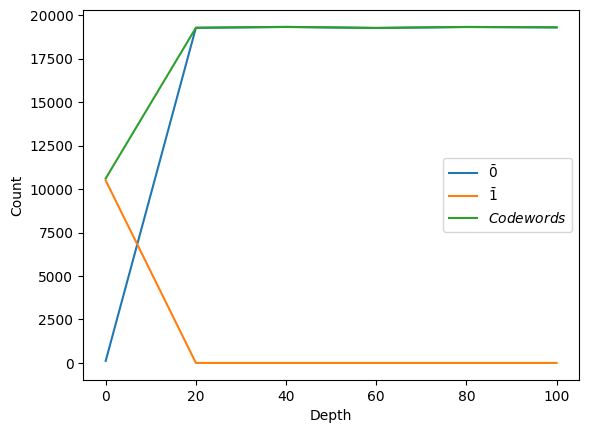

In [55]:
plt.plot(depths, nzeroes, label=r"$\bar{0}$")
plt.plot(depths, nones , label=r"$\bar{1}$")
plt.plot(depths, ncodewords, label=r"$Codewords$")
# plt.plot(depths, nshots * np.ones_like(depths), label=r"$\left| \{ z \} \right|$")
# plt.plot(depths, p_logical_error * np.array(depths) / 2)
plt.xlabel("Depth")
plt.ylabel("Count")

plt.legend();

In [52]:
evals = [expectation(counts, logical0, logical1) for counts in all_counts_ints]
evals

[-0.9779598756710935, 1.0, 1.0, 1.0, 1.0, 1.0]

### With Dynamical decoupling

In [ ]:
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

In [ ]:
job_dd = sampler.run(
    to_run,
    shots=nshots,
)

In [ ]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]

In [ ]:
all_counts_ints_dd = []
for ibm_counts in all_counts_dd:
    counts = Counter()
    for bitstring, count in ibm_counts.items():
        counts[int(bitstring[::-1], 2)] += count
    all_counts_ints_dd.append(counts)

In [ ]:
all_counts_filtered_dd = []
all_counts_filtered0_dd = []
all_counts_filtered1_dd = []

for counts_ints in all_counts_ints_dd:
    filtered = Counter()
    filtered0 = Counter()
    filtered1 = Counter()

    for bitstring, count in counts_ints.items():
        if bitstring in logical0:
            filtered[bitstring] += count
            filtered0[bitstring] += count
        if bitstring in logical1:
            filtered[bitstring] += count
            filtered1[bitstring] += count
    all_counts_filtered_dd.append(filtered)
    all_counts_filtered0_dd.append(filtered0)
    all_counts_filtered1_dd.append(filtered1)

In [ ]:
ncodewords_dd = np.array([sum(filtered.values()) for filtered in all_counts_filtered_dd])
ncodewords_dd

In [ ]:
nzeroes_dd = np.array([sum(filtered0.values()) for filtered0 in all_counts_filtered0_dd])
nzeroes

In [ ]:
nones_dd = np.array([sum(filtered.values()) for filtered in all_counts_filtered1_dd])
nones_dd

In [ ]:
plt.plot(depths, nzeroes_dd / nshots, label=r"$\left| \{ \bar{z} : \bar{z} \in \mathcal{C} \} \right| / N$")
plt.plot(depths, nones_dd / nshots, label=r"$\left| \{ \bar{z} : \bar{z} = \bar{0} \in \mathcal{C} \} \right| / N $")
plt.plot(depths, ncodewords_dd / nshots, label=r"$\left| \{ \bar{z} : \bar{z} = \bar{1} \in \mathcal{C} \} \right| / N$")
# plt.plot(depths, nshots * np.ones_like(depths), label=r"$\left| \{ z \} \right|$")
plt.plot(depths, p_logical_error * np.array(depths) / 2)
plt.xlabel("Depth")
plt.ylabel("Codeword rate")

plt.legend();

In [ ]:
evals_dd = [expectation(counts, logical0, logical1) for counts in all_counts_ints_dd]
evals_dd

In [ ]:
# np.savetxt("codewords_logical0_distance7.txt", list(sorted(logical0)))
# np.savetxt("codewords_logical1_distance7.txt", list(sorted(logical1)))

## Plotting

In [ ]:
plt.plot(depths, [1.0]*len(depths), label="Ideal")
plt.plot(depths, evals, "--o", label="Encoded")
plt.plot(depths, evals_dd, "--o", label="Encoded + DD")

plt.legend();

In [ ]:
plt.semilogy(depths, ncodewords / nshots, label="Encoded")
plt.semilogy(depths, ncodewords_dd / nshots, label="Encoded + DD")

plt.xlabel("Depth")
plt.ylabel("Codeword rate")

plt.legend();

## Save results

In [ ]:
for i, (j, counts_to_save, evals_to_save) in enumerate(zip([job, job_dd], [all_counts, all_counts_dd], [evals, evals_dd])):
    dir = j.job_id() + time_key + idle_strategy
    if i == 1:
        dir += "_dd"
    os.mkdir(dir)

    for depth, counts in zip(depths, counts_to_save):
        with open(f"{dir}/depth_{depth}_counts.pkl", "wb") as f:
            pickle.dump(counts, f)

    with open(f"{dir}/nshots.txt", "w") as f:
        f.write(str(nshots))
    
    with open(f"{dir}/computer.txt", "w") as f:
        f.write(computer.name)

    np.savetxt(f"{dir}/evals.txt", evals_to_save)
    np.savetxt(f"{dir}/physical_qubits.txt", layout[distance])
    np.savetxt(f"{dir}/depths.txt", depths)